# Analyze Stockholm Arlanda Airport Flights using FR24 REST API

This notebook demonstrates how to use the Flightradar24 (FR24) API to analyze flights at a given airport, in this case Stockholm Arlanda Airport (ARN/ESSA).

## Tasks:
1. **Estimate the total number of flights** operating to/from Stockholm Arlanda Airport over the chosen time period.
2. **Identify the most common flight routes** to/from Arlanda during that time.
3. **Determine the most frequent airlines** operating at Arlanda.
4. **Bonus**: Derive how many runways Stockholm Arlanda Airport has.

## Options:
- **Option A**: Count only flights that land or take off within the time period (arrivals and departures).
- **Option B**: Include all flights associated with ARN, such as those en route or parked, even if they don’t land or take off during the period.

## Requirements:
- FR24 API access token (replace `<API_TOKEN>` with your actual token).
- Python packages: `requests`, `pandas`, `numpy`, `math`, `datetime`.

## Approach:
- Use a long-format dataframe where each row is a snapshot of a flight at a specific timestamp, simplifying data management.
- Analyze transitions in flight status to detect arrivals and departures using the following method.
Algorithm for clean_data_arrivals


#### Identify Arrivals using `clean_data_arrivals` Algorithm
- **Filter Flights**: Select rows where:
  - `(Altitude_start >= 10) OR Altitude_start.isna()`
  - `(Altitude_end < 10) OR Altitude_end.isna()`
  - `Destination_start contains 'airport_iata' OR Destination_start.isna()`
- **Check Airport Proximity**: Add `'Coord_end in Airport Bounds'` = `is_flight_in_circle(Lat_end, Lon_end, center_lat, center_lon, radius_km)` for non-null `Lat_end`, `Lon_end`; keep where `True` OR `pd.NA`

#### Identify Departures using `clean_data_departures` Algorithm
- **Input**: Same as `clean_data_arrivals`: `df`, `airport_iata`, `center_lat`, `center_lon`, `radius_km`, `altitude_start` (default 10m)
- **Filter Flights**: Select rows where:
  - `(Altitude_start < 10) OR Altitude_start.isna()`
  - `Origin_start and Origin_end contain 'airport_iata' OR Origin_start.isna()`
- **Check Airport Proximity and Distance**: 
  - Add `'Coord_start in Airport Bounds'` = `is_flight_in_circle(Lat_start, Lon_start, center_lat, center_lon, radius_km)` for non-null `Lat_start`, `Lon_start`
  - Convert `Distance_From_Airport_End_km` and `Max_Possible_Distance_km_end` to numeric, filling NA with `inf`
  - Filter out rows where `(Distance_From_Airport_End_km < Max_Possible_Distance_km_end)` is `False`
  - Keep rows where `'Coord_start in Airport Bounds'` is `True` OR `pd.NA`
- **Output**: Return filtered departures DataFrame with `fr24_id`, timestamps, coordinates, and relevant columns

## Section 1: Setup and Configuration

In [ ]:
# FR24 API TOKEN (replace with your actual token)
API_TOKEN = "<API_TOKEN_HERE>"

# Import required libraries
import json
import pandas as pd
import time
from datetime import datetime, timedelta, timezone
from math import radians, sin, cos, sqrt, atan2
from fr24_helpers import *  # Import all helper functions
from typing import List, Dict
import matplotlib.pyplot as plt

# Configuration
HEADERS = {
    'Accept': 'application/json',
    'Accept-Version': 'v1',
    'Authorization': f'Bearer {API_TOKEN}'
}

## Section 2: Airport Details

In [2]:
# Fetch and display airport details for Stockholm Arlanda
airport_code = 'ARN'  # Using IATA code for simplicity; could use 'ESSA' (ICAO)
RADIUS_KM = 5  # Radius in kilometers to detect flights near airport

airport_details = get_airport_details(airport_code, HEADERS)

if airport_details:
    print("\nAirport Details:")
    print(json.dumps(airport_details, indent=2))
    airport_iata = airport_details.get('iata')
    CENTER_LAT = airport_details.get('lat')
    CENTER_LON = airport_details.get('lon')
    print(f"\nAirport Coordinates: ({CENTER_LAT}, {CENTER_LON})")
    print(f"Search Radius: {RADIUS_KM} km")

get_airport_details() API Cost: $0.0150 (50 credits)

Airport Details:
{
  "name": "Stockholm Arlanda Airport",
  "iata": "ARN",
  "icao": "ESSA",
  "lon": 17.939816,
  "lat": 59.653545,
  "elevation": 137,
  "country": {
    "code": "SE",
    "name": "SWEDEN"
  },
  "city": "Stockholm",
  "state": null,
  "timezone": {
    "name": "Europe/Stockholm",
    "offset": 3600
  }
}

Airport Coordinates: (59.653545, 17.939816)
Search Radius: 5 km


## Section 3: Single Interval Analysis (Demonstration)

Demonstrate the process with a single 20-minute interval before scaling to multiple hours

### Single Interval Inputs

In [3]:
# Define a single 20-minute interval
start_time_demo = datetime(2025, 2, 20, 9, 00, tzinfo=timezone.utc)  # UTC time
INTERVAL_MINUTES = 20  # Time delta between snapshots

# Define end timestamps for the demo interval
end_time_demo = start_time_demo + timedelta(minutes=INTERVAL_MINUTES)
demo_timestamps = [start_time_demo, end_time_demo]

print(f"Demo Start Time: {start_time_demo}")
print(f"Demo End Time: {end_time_demo}")

# Collect snapshot data
demo_snapshot_data = []
demo_api_cost = 0.0
demo_api_credits = 0.0

for ts in demo_timestamps:
    ts_unix = int(ts.timestamp())
    print(f"Fetching snapshot at {ts}")
    flights, cost_info = get_snapshot(ts_unix, airport_code, HEADERS)
    demo_api_cost += cost_info['total_cost']
    demo_api_credits += cost_info['total_credits']
    
    for flight in flights:
        flight_info = {
            'fr24_id': flight.get('fr24_id', ''),
            'Timestamp': ts,
            'Flight': flight.get('flight', ''),
            'Aircraft': flight.get('type', ''),
            'Origin': flight.get('orig_iata', ''),
            'Destination': flight.get('dest_iata', ''),
            'Altitude': flight.get('alt', ''),
            'Ground_Speed': flight.get('gspeed', ''),
            'Vertical_Speed': flight.get('vspeed', ''),
            'Lat': flight.get('lat', ''),
            'Lon': flight.get('lon', ''),
            'Source': flight.get('source', ''),
            'operating_as': flight.get('operating_as', ''),
            'Track': flight.get('track', ''),
            'ETA': pd.to_datetime(flight.get('eta'), utc=True) if flight.get('eta') else pd.NA
        }
        demo_snapshot_data.append(flight_info)

Demo Start Time: 2025-02-20 09:00:00+00:00
Demo End Time: 2025-02-20 09:20:00+00:00
Fetching snapshot at 2025-02-20 09:00:00+00:00
Fetching snapshot at 2025-02-20 09:20:00+00:00


### Single Interval Data Processing

In [4]:
# Create dataframe
demo_df = pd.DataFrame(demo_snapshot_data)

# Enhance with distance
demo_df['distance_to_airport'] = demo_df.apply(
    lambda row: haversine(CENTER_LAT, CENTER_LON, row['Lat'], row['Lon']) 
    if pd.notnull(row['Lat']) and pd.notnull(row['Lon']) else pd.NA,
    axis=1
)

all_flights_demo = len(demo_df['fr24_id'].unique().tolist())

# Pivot demo_df to wide format and enhance with distances
merged_df = pivot_to_wide(demo_df, start_time_demo, end_time_demo)
merged_df = enhance_dataframe_with_distances(merged_df, INTERVAL_MINUTES, CENTER_LAT, CENTER_LON)

# Apply detection logic
demo_arrivals_df = clean_data_arrivals(merged_df, airport_iata, CENTER_LAT, CENTER_LON, RADIUS_KM)
demo_departures_df = clean_data_departures(merged_df, airport_iata, CENTER_LAT, CENTER_LON, RADIUS_KM)

# Extract unique fr24_ids
demo_arrivals = demo_arrivals_df['fr24_id'].unique().tolist()
demo_departures = demo_departures_df['fr24_id'].unique().tolist()

### Single Interval Analysis Results

In [5]:
print("\n=== Single Interval Results ===")
print(f"For time interval: {start_time_demo}, {end_time_demo}")

# Display results
total_operations_demo = len(demo_arrivals) + len(demo_departures)

print(f"\n=== Option 1: Single Interval Analysis - Arrivals and Departures from {airport_code} ===")
print(f"Analysis of time interval of {INTERVAL_MINUTES} minutes:")
print(f"For time interval: {start_time_demo}, {end_time_demo}")

print("\nTotal Arrivals + Departures:")
print(f"- Arrivals: {len(demo_arrivals)} flights")
print(f"- Departures: {len(demo_departures)} flights")
print(f"- Total Arrivals + Departures: {total_operations_demo} flights")

print(f"\n=== Option 2: Single Interval Analysis - All Associated Flights with {airport_code} ===")
print(f"Total Flights: {all_flights_demo}")

# Display final summary
print("\n=== Single Interval API Cost Analysis ===")
print(f"Total API Cost: ${demo_api_cost:.4f} ({demo_api_credits} credits)")
print(f"Total Rows (Snapshots): {all_flights_demo}")


=== Single Interval Results ===
For time interval: 2025-02-20 09:00:00+00:00, 2025-02-20 09:20:00+00:00

=== Option 1: Single Interval Analysis - Arrivals and Departures from ARN ===
Analysis of time interval of 20 minutes:
For time interval: 2025-02-20 09:00:00+00:00, 2025-02-20 09:20:00+00:00

Total Arrivals + Departures:
- Arrivals: 8 flights
- Departures: 1 flights
- Total Arrivals + Departures: 9 flights

=== Option 2: Single Interval Analysis - All Associated Flights with ARN ===
Total Flights: 73

=== Single Interval API Cost Analysis ===
Total API Cost: $0.0048 (16.0 credits)
Total Rows (Snapshots): 73


### Single Interval Sample Data

In [6]:
if demo_arrivals:
    print("Arrivals:")
    display(demo_arrivals_df[['fr24_id', 'Flight_start', 'Flight_end', 'Timestamp_start', 'Timestamp_end', 
                             'Altitude_start', 'Altitude_end', 'Destination_start', 'Origin_start', 
                             'Lat_end', 'Lon_end', 'Distance_From_Airport_End_km', 'Coord_end in Airport Bounds']])
if demo_departures:
    print("Departures:")
    display(demo_departures_df[['fr24_id', 'Flight_start', 'Flight_end', 'Timestamp_start', 'Timestamp_end', 
                                'Altitude_start', 'Altitude_end', 'Origin_start', 'Origin_end', 
                                'Lat_start', 'Lon_start', 'Distance_From_Airport_End_km', 'Max_Possible_Distance_km_end', 
                                'Coord_start in Airport Bounds']])

Arrivals:


,fr24_id,Flight_start,Flight_end,Timestamp_start,Timestamp_end,Altitude_start,Altitude_end,Destination_start,Origin_start,Lat_end,Lon_end,Distance_From_Airport_End_km,Coord_end in Airport Bounds
4,39314035,FR8923,NaN,2025-02-20 09:00:00+00:00,NaT,3800.0,NaN,ARN,MLA,NaN,NaN,<NA>,<NA>
14,393170ed,SK1530,NaN,2025-02-20 09:00:00+00:00,NaT,2300.0,NaN,ARN,LHR,NaN,NaN,<NA>,<NA>
16,39317b4f,BA776,BA776,2025-02-20 09:00:00+00:00,2025-02-20 09:20:00+00:00,22025.0,0.0,ARN,LHR,59.66245,17.96777,1.856352,True
19,39317f81,LO453,NaN,2025-02-20 09:00:00+00:00,NaT,4675.0,NaN,ARN,WAW,NaN,NaN,<NA>,<NA>
22,393184a1,SK1418,SK1418,2025-02-20 09:00:00+00:00,2025-02-20 09:20:00+00:00,20650.0,0.0,ARN,CPH,59.65408,17.93193,0.446998,True
31,39318dc9,D84152,NaN,2025-02-20 09:00:00+00:00,NaT,325.0,NaN,ARN,CPH,NaN,NaN,<NA>,<NA>
36,393192c0,AY805,NaN,2025-02-20 09:00:00+00:00,NaT,1850.0,NaN,ARN,HEL,NaN,NaN,<NA>,<NA>
45,39319d9a,SK864,SK864,2025-02-20 09:00:00+00:00,2025-02-20 09:20:00+00:00,19425.0,0.0,ARN,OSL,59.65328,17.92933,0.589829,True


Departures:


,fr24_id,Flight_start,Flight_end,Timestamp_start,Timestamp_end,Altitude_start,Altitude_end,Origin_start,Origin_end,Lat_start,Lon_start,Distance_From_Airport_End_km,Max_Possible_Distance_km_end,Coord_start in Airport Bounds
53,3931a333,NaN,SK1419,NaT,2025-02-20 09:20:00+00:00,NaN,7875.0,NaN,ARN,NaN,NaN,23.460245,204.337333,<NA>


## Section 4: Multi-Hour Analysis

Extend the analysis to a 24-hour period using 30-minute intervals, collecting all flight data into a single long-format dataframe.

### Multi-Hour Interval Inputs

In [7]:
## Input Parameters for Multi Hour Analysis
total_period_hours = 6
interval_minutes = 30  # Keep 30-minute intervals for cost efficiency
start_time = datetime(2025, 2, 20, 5, 0, tzinfo=timezone.utc)
end_time = start_time + timedelta(hours=total_period_hours)
num_intervals = int(total_period_hours * 60 / interval_minutes)

# Generate timestamps for the intervals
timestamps = [start_time + timedelta(minutes=i * interval_minutes) for i in range(num_intervals + 1)]
print(f"Analysis Period: {start_time} to {end_time}")
print(f"Number of Snapshots: {len(timestamps)}")

Analysis Period: 2025-02-20 05:00:00+00:00 to 2025-02-20 11:00:00+00:00
Number of Snapshots: 13


### Multi-Hour Interval Data Processing

In [ ]:
# Initialize containers for data collection
snapshot_data = []
all_enhanced_data = []  # Store enhanced dataframes
total_api_cost = 0.0
total_api_credits = 0
all_arrivals_df = pd.DataFrame()  # Store all arrivals with enhanced columns
all_departures_df = pd.DataFrame()  # Store all departures with enhanced columns

# Cache for snapshot data
snapshot_cache: Dict[int, List[Dict]] = {}

# Pre-fetch all time snapshots
print("Pre-fetching all snapshots...")
for ts in timestamps:
    ts_unix = int(ts.timestamp())
    print(f"Fetching snapshot at {ts}")
    time.sleep(1)  # Add a delay to avoid rate limiting
    flights, cost_info = get_snapshot(ts_unix, airport_code, HEADERS)
    total_api_cost += cost_info['total_cost']
    total_api_credits += cost_info['total_credits']
    
    # Store flight data in cache
    snapshot_cache[ts_unix] = [{
        'fr24_id': flight.get('fr24_id', ''),
        'Timestamp': ts,
        'Flight': flight.get('flight', ''),
        'Aircraft': flight.get('type', ''),
        'Origin': flight.get('orig_iata', ''),
        'Destination': flight.get('dest_iata', ''),
        'Altitude': flight.get('alt', ''),
        'Ground_Speed': flight.get('gspeed', ''),
        'Vertical_Speed': flight.get('vspeed', ''),
        'Lat': flight.get('lat', ''),
        'Lon': flight.get('lon', ''),
        'Source': flight.get('source', ''),
        'operating_as': flight.get('operating_as', ''),
        'Track': flight.get('track', ''),
        'ETA': pd.to_datetime(flight.get('eta'), utc=True) if flight.get('eta') else pd.NA
    } for flight in flights]


# Process each interval
for i in range(len(timestamps) - 1):
    interval_start = timestamps[i]
    interval_end = timestamps[i + 1]
    print(f"\n=== Processing Interval: {interval_start} to {interval_end} ===")
    
    # Collect snapshot data for the interval
    interval_data = []
    for ts in [interval_start, interval_end]:
        ts_unix = int(ts.timestamp())
        
        if ts_unix in snapshot_cache:
            interval_data.extend(snapshot_cache[ts_unix])
            snapshot_data.extend(snapshot_cache[ts_unix])  # Also add to complete dataset
        
    # Process interval data - Remove duplicates first
    interval_df = pd.DataFrame(interval_data).drop_duplicates(['fr24_id', 'Timestamp'])
    interval_df['distance_to_airport'] = interval_df.apply(
        lambda row: haversine(CENTER_LAT, CENTER_LON, row['Lat'], row['Lon'])
        if pd.notnull(row['Lat']) and pd.notnull(row['Lon']) else pd.NA,
        axis=1
    )
    
    print(f"Unique flights in interval: {interval_df['fr24_id'].nunique()}")
    print(f"Total records after removing duplicates: {len(interval_df)}")
    
    # Convert to wide format and enhance with distances
    merged_df = pivot_to_wide(interval_df, interval_start, interval_end)
    merged_df = enhance_dataframe_with_distances(merged_df, interval_minutes, CENTER_LAT, CENTER_LON)
    all_enhanced_data.append(merged_df)  # Store enhanced dataframe
    
    # Apply detection logic and store enhanced dataframes
    arrivals_df = clean_data_arrivals(merged_df, airport_iata, CENTER_LAT, CENTER_LON, RADIUS_KM)
    departures_df = clean_data_departures(merged_df, airport_iata, CENTER_LAT, CENTER_LON, RADIUS_KM)
    
    # Get unique flights for this interval
    interval_arrivals = arrivals_df.drop_duplicates(['fr24_id', 'Timestamp_start', 'Timestamp_end'])
    interval_departures = departures_df.drop_duplicates(['fr24_id', 'Timestamp_start', 'Timestamp_end'])
    
    # Only concatenate if not empty
    if not interval_arrivals.empty:
        all_arrivals_df = pd.concat([all_arrivals_df, interval_arrivals], ignore_index=True)
    if not interval_departures.empty:
        all_departures_df = pd.concat([all_departures_df, interval_departures], ignore_index=True)
    
    # Display interval results
    print(f"\nInterval Operations:")
    print(f"- Arrivals: {len(interval_arrivals)}")
    print(f"- Departures: {len(interval_departures)}")
    print(f"- Total: {len(interval_arrivals) + len(interval_departures)}")

Pre-fetching all snapshots...
Fetching snapshot at 2025-02-20 05:00:00+00:00
Fetching snapshot at 2025-02-20 05:30:00+00:00
Fetching snapshot at 2025-02-20 06:00:00+00:00
Fetching snapshot at 2025-02-20 06:30:00+00:00
Fetching snapshot at 2025-02-20 07:00:00+00:00
Fetching snapshot at 2025-02-20 07:30:00+00:00
Fetching snapshot at 2025-02-20 08:00:00+00:00
Fetching snapshot at 2025-02-20 08:30:00+00:00
Fetching snapshot at 2025-02-20 09:00:00+00:00
Fetching snapshot at 2025-02-20 09:30:00+00:00
Fetching snapshot at 2025-02-20 10:00:00+00:00
Fetching snapshot at 2025-02-20 10:30:00+00:00
Fetching snapshot at 2025-02-20 11:00:00+00:00

=== Processing Interval: 2025-02-20 05:00:00+00:00 to 2025-02-20 05:30:00+00:00 ===
Unique flights in interval: 42
Total records after removing duplicates: 61

Interval Operations:
- Arrivals: 4
- Departures: 15
- Total: 19

=== Processing Interval: 2025-02-20 05:30:00+00:00 to 2025-02-20 06:00:00+00:00 ===
Unique flights in interval: 52
Total records afte

### Multi-Hour Analysis Results

In [9]:
# Create complete enhanced dataset
all_enhanced_df = pd.concat(all_enhanced_data, ignore_index=True)
snapshot_df = pd.DataFrame(snapshot_data)
snapshot_df = snapshot_df.drop_duplicates(['fr24_id', 'Timestamp'])  # Remove duplicates from raw data
all_flights_df = snapshot_df.sort_values(['fr24_id', 'Timestamp'])

# Enhance with distance to airport
all_flights_df['distance_to_airport'] = all_flights_df.apply(
    lambda row: haversine(CENTER_LAT, CENTER_LON, row['Lat'], row['Lon'])
    if pd.notnull(row['Lat']) and pd.notnull(row['Lon']) else pd.NA,
    axis=1
)

# Remove duplicates considering the full context
all_arrivals_df = all_arrivals_df.sort_values(['fr24_id', 'Timestamp_start', 'Timestamp_end']).groupby('fr24_id').last().reset_index()
all_departures_df = all_departures_df.sort_values(['fr24_id', 'Timestamp_start', 'Timestamp_end']).groupby('fr24_id').first().reset_index()

# Get unique sets of flight IDs
all_arrivals = set(all_arrivals_df['fr24_id'])
all_departures = set(all_departures_df['fr24_id'])

print(f"\n=== Option 1: Final Detailed Analysis - Arrivals and Departures from {airport_code} ===")
print(f"Analysis of {total_period_hours} hours Interval split in interval of {interval_minutes} minutes:")
print(f"For time interval: {start_time}, {end_time}")

print("\nTotal Arrivals + Departures:")
print(f"- Arrivals: {len(all_arrivals)} flights")
print(f"- Departures: {len(all_departures)} flights")
print(f"- Total Arrivals + Departures: {len(all_arrivals) + len(all_departures)} flights")

print(f"\n=== Option 2: All Associated Flights with {airport_code} ===")
print(f"Total Flights: {all_flights_df['fr24_id'].nunique()}")

# Display final summary
print("\n=== Multi hour API Cost Analysis ===")
print(f"Total API Cost: ${total_api_cost:.4f} ({total_api_credits} credits)")
print(f"Total Rows (Snapshots): {len(all_flights_df)}")


=== Option 1: Final Detailed Analysis - Arrivals and Departures from ARN ===
Analysis of 6 hours Interval split in interval of 30 minutes:
For time interval: 2025-02-20 05:00:00+00:00, 2025-02-20 11:00:00+00:00

Total Arrivals + Departures:
- Arrivals: 78 flights
- Departures: 102 flights
- Total Arrivals + Departures: 180 flights

=== Option 2: All Associated Flights with ARN ===
Total Flights: 212

=== Multi hour API Cost Analysis ===
Total API Cost: $0.0312 (104 credits)
Total Rows (Snapshots): 685


### Multi Hour Sample Data

In [10]:
# Display sample enhanced arrival data
print("\nSample Enhanced Arrival Data (showing distance and position analysis):")
if not all_arrivals_df.empty:
    columns_to_show = ['fr24_id', 'Flight_start', 'Timestamp_start', 'Timestamp_end', 'Altitude_start', 'Altitude_end',
                      'Distance_From_Airport_Start_km', 'Distance_From_Airport_End_km',
                      'Coord_end in Airport Bounds']
    display(all_arrivals_df[columns_to_show].head())

# Display sample enhanced departure data
print("\nSample Enhanced Departure Data (showing distance and position analysis):")
if not all_departures_df.empty:
    columns_to_show = ['fr24_id', 'Flight_start', 'Timestamp_start', 'Timestamp_end', 'Altitude_start', 'Altitude_end',
                      'Distance_From_Airport_Start_km', 'Distance_From_Airport_End_km',
                      'Coord_start in Airport Bounds', 'Max_Possible_Distance_km_end']
    display(all_departures_df[columns_to_show].head())


Sample Enhanced Arrival Data (showing distance and position analysis):


,fr24_id,Flight_start,Timestamp_start,Timestamp_end,Altitude_start,Altitude_end,Distance_From_Airport_Start_km,Distance_From_Airport_End_km,Coord_end in Airport Bounds
0,392fca02,TG960,2025-02-20 06:00:00+00:00,NaT,3075.0,NaN,20.816488,None,None
1,39308011,SK904,2025-02-20 06:00:00+00:00,NaT,5275.0,NaN,23.554557,None,None
2,393084e3,QR169,2025-02-20 05:00:00+00:00,2025-02-20 05:30:00+00:00,39450.0,0.0,200.049929,1.227881,True
3,3930eafa,CAO3105,2025-02-20 10:30:00+00:00,2025-02-20 11:00:00+00:00,17375.0,0.0,144.698672,1.479713,True
4,3930fa20,SK958,2025-02-20 10:30:00+00:00,NaT,40250.0,NaN,208.552634,None,None



Sample Enhanced Departure Data (showing distance and position analysis):


,fr24_id,Flight_start,Timestamp_start,Timestamp_end,Altitude_start,Altitude_end,Distance_From_Airport_Start_km,Distance_From_Airport_End_km,Coord_start in Airport Bounds,Max_Possible_Distance_km_end
0,3931101c,SK1415,2025-02-20 05:00:00+00:00,2025-02-20 05:30:00+00:00,0.0,37750.0,0.609637,260.233966,True,411.144
1,3931390f,AF1463,2025-02-20 05:00:00+00:00,2025-02-20 05:30:00+00:00,0.0,0.0,1.249067,1.356774,True,inf
2,39313cd3,None,NaT,2025-02-20 05:30:00+00:00,NaN,27250.0,None,167.123283,None,463.000
3,39313d45,CAO3157,2025-02-20 05:00:00+00:00,2025-02-20 05:30:00+00:00,0.0,31700.0,0.31139,168.432242,True,416.700
4,3931418c,FR7603,2025-02-20 05:00:00+00:00,2025-02-20 05:30:00+00:00,0.0,39000.0,1.120375,298.902182,True,449.110


## Section 5: Further Analysis (Routes and Airlines)

In [11]:
# Most Common Routes
routes = all_flights_df.groupby(['Origin', 'Destination'])['fr24_id'].nunique().reset_index(name='Count')
common_routes = routes.sort_values('Count', ascending=False).head(10)
print("=== Most Common Routes ===")
display(common_routes)

# Most Frequent Airlines using operating_as ICAO codes
airlines_df = all_flights_df[['fr24_id', 'operating_as']].drop_duplicates()
airlines_df = airlines_df[airlines_df['operating_as'].notna()]  # Remove rows with missing operating_as
airline_counts = airlines_df.groupby('operating_as')['fr24_id'].count().reset_index(name='Count')
frequent_airlines = airline_counts.sort_values('Count', ascending=False).head(10)

# Get airline names using Airlines Light API
airline_names = {}
for icao in frequent_airlines['operating_as']:
    airline_info = get_airline_info(icao, HEADERS)
    if airline_info:
        airline_names[icao] = airline_info.get('name', 'Unknown')
    else:
        airline_names[icao] = 'Unknown'

# Add airline names to the dataframe
frequent_airlines['Airline_Name'] = frequent_airlines['operating_as'].map(airline_names)

print("\n=== Most Frequent Airlines ===")
print("(Using operating airline ICAO codes and FR24 Airlines API)")
display(frequent_airlines[['operating_as', 'Airline_Name', 'Count']].rename(
    columns={'operating_as': 'ICAO Code', 'Count': 'Number of Flights'}
))

=== Most Common Routes ===


,Origin,Destination,Count
18,ARN,CPH,7
78,CPH,ARN,7
29,ARN,HEL,6
90,HEL,ARN,6
101,LLA,ARN,6
51,ARN,OSL,5
9,ARN,AMS,5
35,ARN,LHR,4
99,LHR,ARN,4
121,UME,ARN,4



=== Most Frequent Airlines ===
(Using operating airline ICAO codes and FR24 Airlines API)


,ICAO Code,Airline_Name,Number of Flights
39,SZS,SAS Connect,44
28,NSZ,Norwegian Air Sweden,26
34,SAS,SAS,24
9,BRX,BRA,18
32,RYR,Ryanair,9
2,APF,populAir,8
6,BCY,CityJet,6
16,FIN,Finnair,5
24,KLM,KLM,4
13,DLH,Lufthansa,4


## Section 6: Bonus - Runway Information

Attempt to derive runway count, though limited by API data from 20 Feb 8pm UTC to 8:12pm UTC

In [12]:
## Input Parameters for Multi Hour Analysis
total_period_hours = 0.2  # Total period in hours
interval_minutes = 0.25  # intervals for cost efficiency
start_time = datetime(2025, 2, 20, 20, 00, tzinfo=timezone.utc)  # UTC time
end_time = start_time + timedelta(hours=total_period_hours)
num_intervals = int(total_period_hours * 60 / interval_minutes)


# Calculate bounds
bounds = calculate_bounds(CENTER_LAT, CENTER_LON, RADIUS_KM)

# Static constraints
altitude_ranges = "0-30"  # Altitude < 20m
gspeed = "20-180"           # Ground Speed > 20 knots

# Generate timestamps for the intervals
timestamps = [start_time + timedelta(minutes=i * interval_minutes) for i in range(num_intervals + 1)]
print(f"Analysis Period: {start_time} to {end_time}")
print(f"Number of Snapshots: {len(timestamps)}")


# Initialize containers for data collection
all_enhanced_data = []  # Store enhanced dataframes
snapshot_track_data = []
total_api_cost = 0.0
total_api_credits = 0

# Cache for snapshot data
snapshot_cache: Dict[int, List[Dict]] = {}

# Pre-fetch all snapshots
print("Pre-fetching all snapshots...")
for ts in timestamps:
    ts_unix = int(ts.timestamp())
    print(f"Fetching snapshot at {ts}")
    time.sleep(1)  # Add a delay to avoid rate limiting
    flights, cost_info = get_snapshot(
        timestamp=ts_unix,
        airport_code=airport_code,
        headers=HEADERS,
        limit=1000,  # Your default, adjust if needed
        bounds=bounds,
        gspeed=gspeed,
        altitude_ranges=altitude_ranges
    )
    total_api_cost += cost_info['total_cost']
    total_api_credits += cost_info['total_credits']
    
    # Store flight data in cache
    snapshot_cache[ts_unix] = [{
        'fr24_id': flight.get('fr24_id', ''),
        'Timestamp': ts,
        'Flight': flight.get('flight', ''),
        'Aircraft': flight.get('type', ''),
        'Origin': flight.get('orig_iata', ''),
        'Destination': flight.get('dest_iata', ''),
        'Altitude': flight.get('alt', ''),
        'Ground_Speed': flight.get('gspeed', ''),
        'Vertical_Speed': flight.get('vspeed', ''),
        'Lat': flight.get('lat', ''),
        'Lon': flight.get('lon', ''),
        'Source': flight.get('source', ''),
        'operating_as': flight.get('operating_as', ''),
        'Track': flight.get('track', ''),
        'ETA': pd.to_datetime(flight.get('eta'), utc=True) if flight.get('eta') else pd.NA
    } for flight in flights]


# Process each interval using cached snapshots
for i in range(len(timestamps) - 1):
    interval_start = timestamps[i]
    # Note: Your code only uses interval_start, so we'll use that from the cache
    print(f"\n=== Processing Interval: {interval_start} ===")
    
    # Get snapshot data for the interval from cache
    interval_data = []
    ts_unix = int(interval_start.timestamp())
    if ts_unix in snapshot_cache:
        interval_data.extend(snapshot_cache[ts_unix])
        snapshot_track_data.extend(snapshot_cache[ts_unix])  # Also add to complete dataset
    
    # Process interval data - Remove duplicates first
    interval_df = pd.DataFrame(interval_data).drop_duplicates(['fr24_id', 'Timestamp'])

    if len(interval_df):
        interval_df['distance_to_airport'] = interval_df.apply(
            lambda row: haversine(CENTER_LAT, CENTER_LON, row['Lat'], row['Lon'])
            if pd.notnull(row['Lat']) and pd.notnull(row['Lon']) else pd.NA,
            axis=1
        )
        print(f"Unique flights in interval: {interval_df['fr24_id'].nunique()}")
        print(f"Total records after removing duplicates: {len(interval_df)}")
        
        # Convert to wide format and enhance with distances
        # Note: Since you only use interval_start, interval_end is not needed here
        merged_df = pivot_to_wide(interval_df, interval_start, interval_start + timedelta(minutes=interval_minutes))
        merged_df = enhance_dataframe_with_distances(merged_df, interval_minutes, CENTER_LAT, CENTER_LON)
        all_enhanced_data.append(merged_df)  # Store enhanced dataframe

# Display final summary
print("\n=== Multi hour API Cost Analysis ===")
print(f"Total API Cost: ${total_api_cost:.4f} ({total_api_credits} credits)")
print(f"Total Rows (Snapshots): {len(all_flights_df)}")

Analysis Period: 2025-02-20 20:00:00+00:00 to 2025-02-20 20:12:00+00:00
Number of Snapshots: 49
Pre-fetching all snapshots...
Fetching snapshot at 2025-02-20 20:00:00+00:00
Fetching snapshot at 2025-02-20 20:00:15+00:00
Fetching snapshot at 2025-02-20 20:00:30+00:00
Fetching snapshot at 2025-02-20 20:00:45+00:00
Fetching snapshot at 2025-02-20 20:01:00+00:00
Fetching snapshot at 2025-02-20 20:01:15+00:00
Fetching snapshot at 2025-02-20 20:01:30+00:00
Fetching snapshot at 2025-02-20 20:01:45+00:00
Fetching snapshot at 2025-02-20 20:02:00+00:00
Fetching snapshot at 2025-02-20 20:02:15+00:00
Fetching snapshot at 2025-02-20 20:02:30+00:00
Fetching snapshot at 2025-02-20 20:02:45+00:00
Fetching snapshot at 2025-02-20 20:03:00+00:00
Fetching snapshot at 2025-02-20 20:03:15+00:00
Fetching snapshot at 2025-02-20 20:03:30+00:00
Fetching snapshot at 2025-02-20 20:03:45+00:00
Fetching snapshot at 2025-02-20 20:04:00+00:00
Fetching snapshot at 2025-02-20 20:04:15+00:00
Fetching snapshot at 2025-02

In [18]:
# Import all_flights_df from a csv
#all_flights_df = pd.read_csv('./Outputs/all_flights_df_track.csv')

# Create complete enhanced dataset
#all_enhanced_df = pd.concat(all_enhanced_data, ignore_index=True)
snapshot_tracks_df = pd.DataFrame(snapshot_track_data)
snapshot_tracks_df = snapshot_tracks_df.drop_duplicates(['fr24_id', 'Timestamp'])  # Remove duplicates from raw data
tracks_df = snapshot_tracks_df.sort_values(['fr24_id', 'Timestamp'])


# Enhance with distance to airport
tracks_df['distance_to_airport'] = tracks_df.apply(
    lambda row: haversine(CENTER_LAT, CENTER_LON, row['Lat'], row['Lon'])
    if pd.notnull(row['Lat']) and pd.notnull(row['Lon']) else pd.NA,
    axis=1
)


In [22]:
runway_df = tracks_df[(tracks_df['Altitude'] <= 10) &
    (tracks_df['Ground_Speed'] > 25)]  # Filter for low altitude flights

# Group by fr24_id and collect all coordinates and tracks as lists
grouped_flights = runway_df.groupby('fr24_id').agg({
    'Lat': lambda x: list(x),  # Collect all latitude points
    'Lon': lambda x: list(x),  # Collect all longitude points
    'Track': lambda x: list(x)  # Collect all track values
})

# Sort values within each list by Timestamp to ensure correct path order
for fr24_id in grouped_flights.index:
    flight_data = runway_df[runway_df['fr24_id'] == fr24_id].sort_values('Timestamp')
    grouped_flights.at[fr24_id, 'Lat'] = flight_data['Lat'].tolist()
    grouped_flights.at[fr24_id, 'Lon'] = flight_data['Lon'].tolist()
    grouped_flights.at[fr24_id, 'Track'] = flight_data['Track'].tolist()

print(f"Number of unique flights (fr24_id): {len(grouped_flights)}")

Number of unique flights (fr24_id): 5


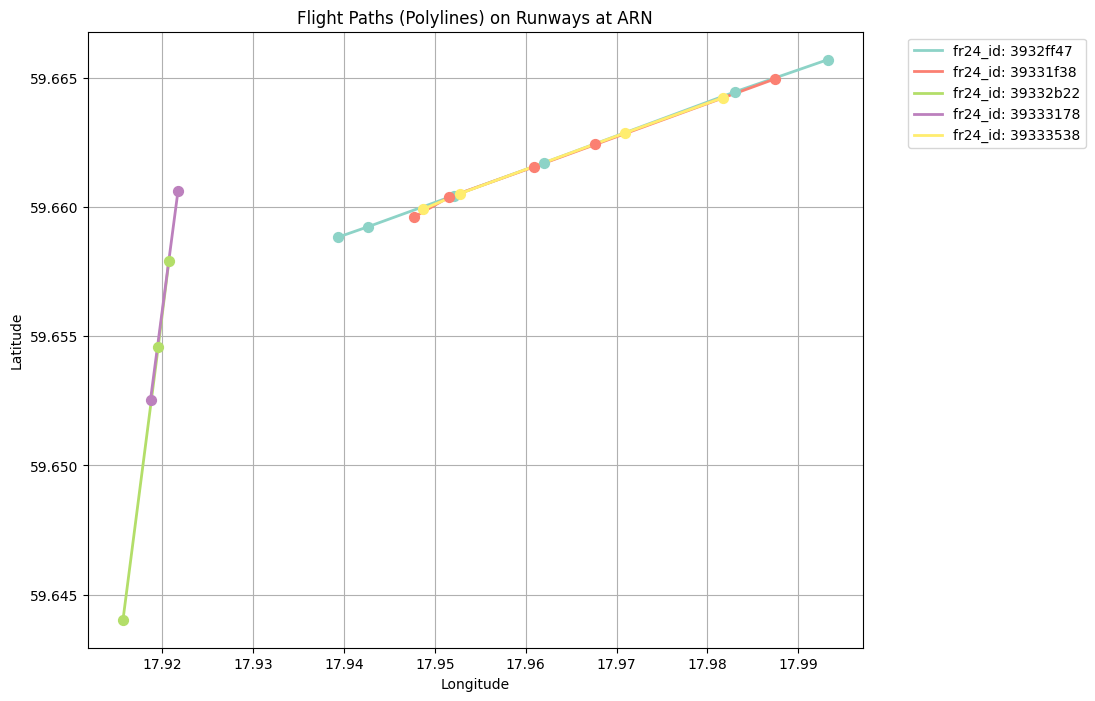

In [20]:
plt.figure(figsize=(10, 8))

# Colors for each flight (cycling through a colormap)
colors = plt.cm.Set3(np.linspace(0, 1, len(grouped_flights)))

for idx, (fr24_id, row) in enumerate(grouped_flights.iterrows()):
    lat = row['Lat']
    lon = row['Lon']
    plt.plot(lon, lat, label=f"fr24_id: {fr24_id}", color=colors[idx], linestyle='-', linewidth=2)
    # Plot points as dots for clarity
    plt.scatter(lon, lat, color=colors[idx], s=50, zorder=5)

plt.title("Flight Paths (Polylines) on Runways at ARN")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [21]:
print("=== Bonus: Runway Information ===")
print("The FR24 API does not provide direct runway data in the /airports/full endpoint.")
print("Based on official sources, Stockholm Arlanda Airport (ARN) has 3 runways: 01L/19R, 01R/19L, 08/26.")

# Validation with known data
print("Note: Stockholm Arlanda Airport is known to have 3 runways: 01L/19R, 01R/19L, 08/26")

=== Bonus: Runway Information ===
The FR24 API does not provide direct runway data in the /airports/full endpoint.
Based on official sources, Stockholm Arlanda Airport (ARN) has 3 runways: 01L/19R, 01R/19L, 08/26.
Note: Stockholm Arlanda Airport is known to have 3 runways: 01L/19R, 01R/19L, 08/26


## Reflections

### API Data Availability
- **Provided**: Real-time and historical flight positions, including origin, destination, and aircraft details, sufficient for most tasks.
- **Missing**: Direct runway information; flight schedules for exact arrival/departure times; precise airline codes (approximated from flight numbers).
- **Workaround**: Use ground status transitions and external runway data.

### API Credit Optimization
- Used `/historic/flight-positions/full` (8 credits/flight) with 30-minute intervals to balance cost and coverage.
- Alternative: `/flight-tracks` (40 credits/flight) could track individual flights but is costlier and unnecessary here.

### Insights
- **FR24 API**: Robust for positional data; cost management is key with large datasets.
- **Aviation**: ARN’s traffic includes diverse routes and airlines; 30-minute snapshots may miss rapid turnarounds.